<a href="https://colab.research.google.com/github/jindalk/pytorch_projects/blob/main/03_pbmc_3k_classifier_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot some key evaluation metrics for our classifier
1.   We already plotted training and validation loss so we will focus on other metrics now



In [ ]:
#connect drive
from google.colab import drive
drive.mount('/content/drive')

#add custom lib path
import os, sys
sys.path.append('/content/drive/MyDrive/libs')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import shap

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

import scanpy as sc

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1838, 50)
    self.bn1 = nn.BatchNorm1d(50)
    self.fc2 = nn.Linear(50,10)
    self.bn2 = nn.BatchNorm1d(10)
    self.fc3 = nn.Linear(10,1)

  def forward(self, input):
    f1 = self.fc1(input)
    f1 = F.relu(self.bn1(f1))

    f2 = self.fc2(f1)
    f2 = F.relu(self.bn2(f2))

    f3 = F.sigmoid(self.fc3(f2))
    return f3

net = Net()

In [ ]:


#load trained model
net.load_state_dict(torch.load('/content/drive/MyDrive/single_cell/data/pbmc_3k_model.pth'))

<ipython-input-7-96670d6d39dd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('/content/drive/MyDrive/single_cell/data/pbmc_3k_model.pth'))


<All keys matched successfully>

In [ ]:
#load and setup data
gex = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc.csv', index_col=0)
meta = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc_meta.csv', index_col=0)

assert((gex.index == meta.index).all())

labels = meta['immune'].apply(lambda x: 0. if x=='adaptive' else 1.).values
labels = torch.from_numpy(labels)
labels = labels.type(torch.float32)

data = torch.from_numpy(gex.values)

train_data, test_data, train_labels, test_labels, train_idx, test_idx = train_test_split(data, labels, gex.index.values, test_size = 0.2,
                                                                    random_state = 42, stratify = labels)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1,
                                                                    random_state = 42, stratify = train_labels)

len(train_labels), len(val_labels), len(test_labels)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [ ]:
#Confusion matrix
net.eval()

with torch.no_grad():
  preds = net(test_data.float())
  pred_discrete = [0 if x < 0.5 else 1 for x in preds]

In [ ]:
cm = confusion_matrix(test_labels, pred_discrete)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Adaptive", "Innate"])

#0 is adaptive, 1 is innate

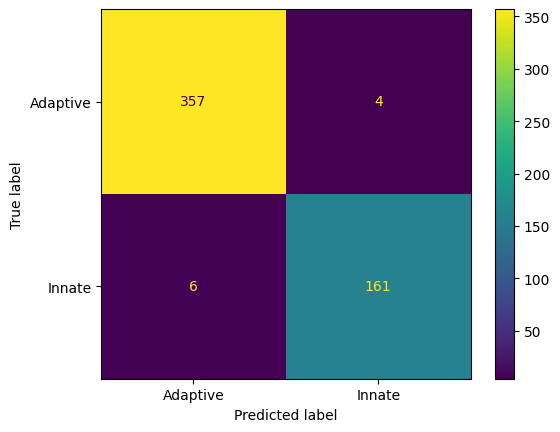

In [ ]:
disp.plot()

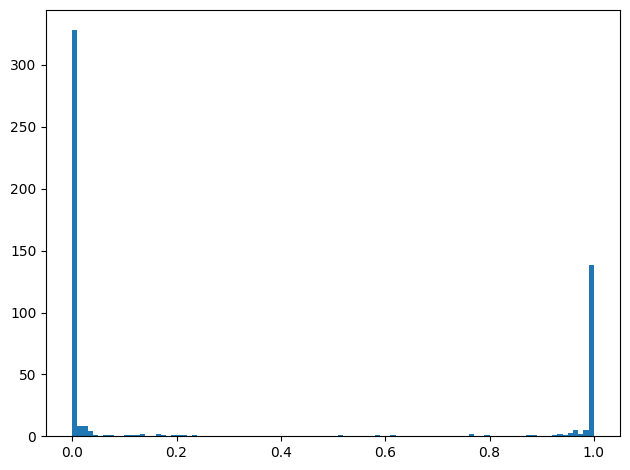

In [ ]:
plt.hist(preds, bins=100)
plt.tight_layout()

Text(0.5, 1.0, 'ROC curve (AUC = 0.99731)')

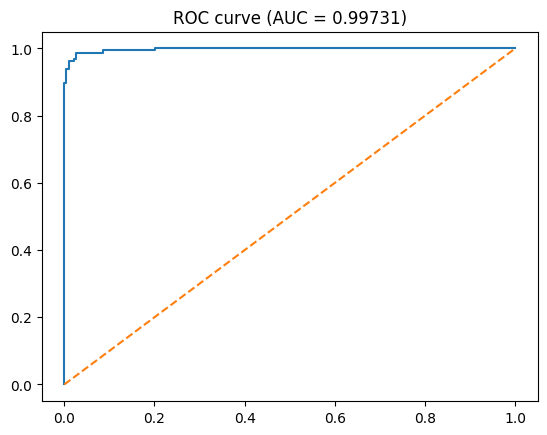

In [ ]:
fpr, tpr, th = roc_curve(test_labels, preds)
auc = roc_auc_score(test_labels, preds)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'ROC curve (AUC = {auc:.5f})')

Text(0.5, 1.0, 'PR curve (AUPR = 0.99516)')

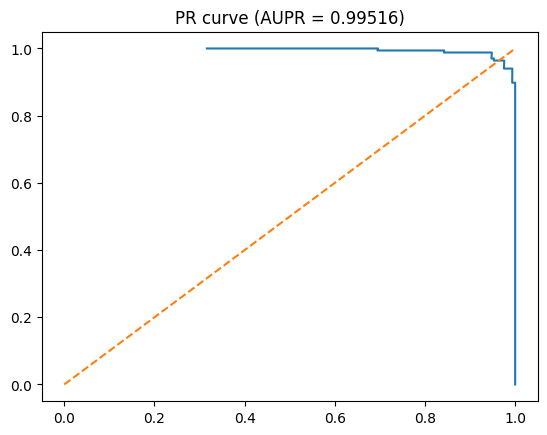

In [ ]:
#precision recall characteristics
p,r, _ = precision_recall_curve(test_labels, preds)
aupr = average_precision_score(test_labels, preds)

plt.figure()
plt.plot(p, r)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'PR curve (AUPR = {aupr:.5f})')

In [ ]:
#plot umap of test data points
adata = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [ ]:
adata.obs['immune'] = 'innate'
adata.obs.loc[adata.obs.louvain.isin(['CD4 T cells', 'CD8 T cells', 'B cells']),'immune'] = 'adaptive'

adata_test = adata[test_idx].copy()
assert((adata_test.obs_names.values == test_idx).all())

In [ ]:
#add to meta is label was predicted correctly or not
adata_test.obs['pred_state'] = (test_labels == np.array(pred_discrete)).numpy()
adata_test.obs['pred_state'] = adata_test.obs['pred_state'].apply(lambda x:"Correct" if x else "Incorrect")

In [ ]:
adata_test.uns['pred_state_colors'] = ['#5ec962', '#3b528b']

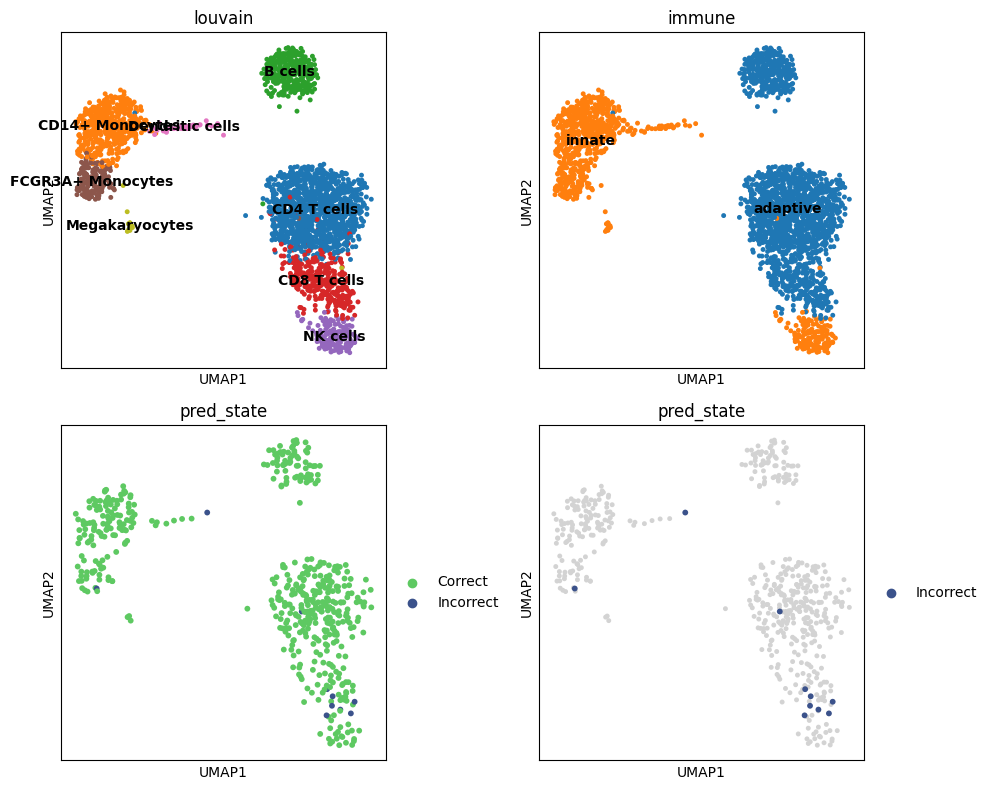

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2)


ax = plt.subplot(gs[0])
sc.pl.umap(adata, color = 'louvain', ax=ax, show=False, s=50, legend_loc= 'on data')

ax = plt.subplot(gs[1])
sc.pl.umap(adata, color = 'immune', ax=ax, show=False, s=50, legend_loc= 'on data')

ax=plt.subplot(gs[2])
sc.pl.umap(adata_test, color = 'pred_state', ax=ax, s=70, show=False)

ax=plt.subplot(gs[3])
sc.pl.umap(adata_test, s=50, ax=ax, show=False)
sc.pl.umap(adata_test[adata_test.obs.pred_state=='Incorrect'], color = 'pred_state', ax=ax, s=70, show=False)

plt.tight_layout()

In [ ]:
#most of the misclassifications are at the T-cell, Nk cell boundary, which makes sense given their shared origin

In [ ]:
#Let's run this on healthy PBMCs from a different donor, seqeunced with a newer version of the technology
gex_new = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_multimodal_2023_sct_6k.csv', index_col=0)

In [ ]:
meta_new = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_multimodal_2023_sct_meta_6k.csv', index_col=0)

In [ ]:
meta_new['celltype.l1'].unique()

array(['NK', 'other T', 'B', 'CD8 T', 'CD4 T', 'Mono', 'DC', 'other'],
      dtype=object)

In [ ]:
meta_new['immune'] = 'innate'
meta_new.loc[meta_new['celltype.l1'].isin(['other T', 'B', 'CD8 T', 'CD4 T']), 'immune'] = 'adaptive'

In [ ]:
#some genes from the original dataset arent present in the new one, this could be real missing genes or just mismatched names due to different naming conventions. For now, we will add zeros in place of those missing genes
new_genes = gex.columns[~gex.columns.isin(gex_new.columns.values)]

In [ ]:
new_genes.shape

(161,)

In [ ]:
#some genes are not present in the new data
new_genes_df = pd.DataFrame(0, columns = new_genes, index = gex_new.index)

In [ ]:
gex_new = pd.concat((gex_new, new_genes_df), axis=1)
gex_new = gex_new.loc[:, gex.columns.values].copy()

In [ ]:
gex_new.shape

(6000, 1838)

In [ ]:
with torch.no_grad():
  new_predictions = net(torch.from_numpy(gex_new.values).float())
  new_predictions_discrete = [0 if x < 0.5 else 1 for x in new_predictions]

In [ ]:
labels_new = meta_new.loc[gex_new.index,'immune'].apply(lambda x:0 if x=='adaptive' else 1).values

In [ ]:
cm_new = confusion_matrix(labels_new, new_predictions_discrete)
disp_new = ConfusionMatrixDisplay(confusion_matrix=cm_new, display_labels=["Adaptive", "Innate"])

#0 is adaptive, 1 is innate

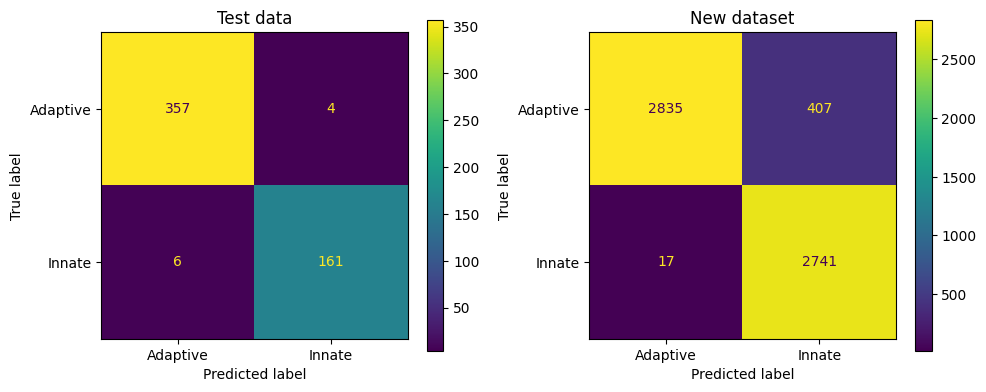

In [ ]:
fig = plt.figure(figsize = (10,4))
gs=GridSpec(1,2)

ax=plt.subplot(gs[0])
disp.plot(ax=ax)
plt.title("Test data")

ax=plt.subplot(gs[1])
disp_new.plot(ax=ax)
plt.title("New dataset")
plt.tight_layout()

We can see a lot more Adaptive cells have been mis-classified as Innate in the new dataset. Let us continue looking at other metrics to understand its performance further.

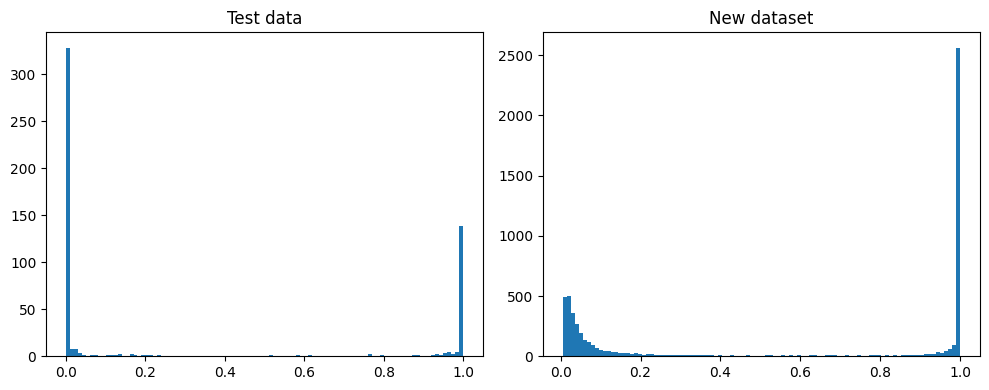

In [ ]:
fig = plt.figure(figsize = (10,4))
gs=GridSpec(1,2)

ax=plt.subplot(gs[0])
plt.hist(preds.numpy(), bins=100)
plt.title("Test data")
plt.tight_layout()

ax=plt.subplot(gs[1])
plt.hist(new_predictions.numpy(), bins=100)
plt.title("New dataset")
plt.tight_layout()

In [ ]:
fpr_new, tpr_new, th_new = roc_curve(labels_new, new_predictions)
auc_new = roc_auc_score(labels_new, new_predictions)

Text(0.5, 1.0, 'New dataset (AUC = 0.99410)')

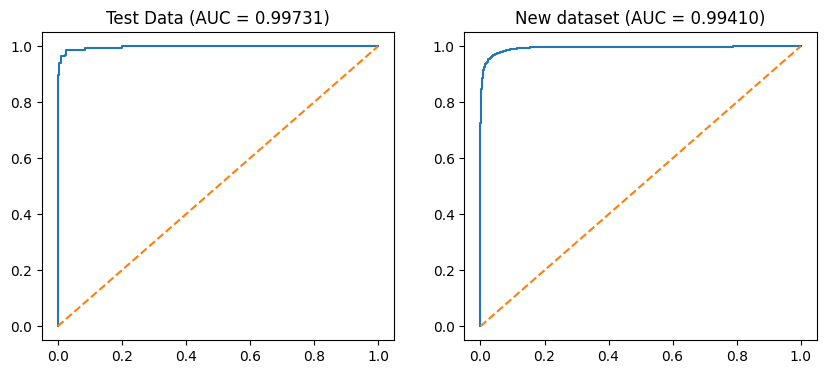

In [ ]:
plt.figure(figsize=(10,4))
gs=GridSpec(1,2)

ax = plt.subplot(gs[0])

ax = plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'Test Data (AUC = {auc:.5f})')


ax = plt.subplot(gs[1])

ax = plt.plot(fpr_new, tpr_new)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'New dataset (AUC = {auc_new:.5f})')

In [ ]:
#precision recall characteristics
p_new,r_new, _ = precision_recall_curve(labels_new, new_predictions)
aupr_new = average_precision_score(labels_new, new_predictions)

Text(0.5, 1.0, 'New dataset (AUPR = 0.99417)')

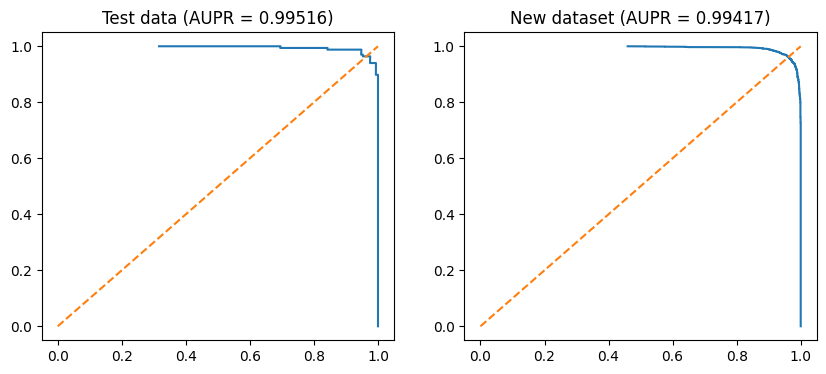

In [ ]:
plt.figure(figsize=(10,4))
gs=GridSpec(1,2)

ax = plt.subplot(gs[0])
plt.plot(p, r)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'Test data (AUPR = {aupr:.5f})')


ax = plt.subplot(gs[1])
plt.plot(p_new, r_new)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'New dataset (AUPR = {aupr_new:.5f})')

The classifier performs surprisingly well on the new dataset, despite missing values for 161 input genes. Next, let's visualize these predictions on the single cell data itself.

In [ ]:
adata_new = sc.read_h5ad("/content/drive/MyDrive/single_cell/data/pbmc_multimodal_2023_sct_6k.h5ad")

In [ ]:
adata_new

AnnData object with n_obs × n_vars = 6000 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index'
    var: 'highly_variable'
    uns: 'pca', 'spca'
    obsm: 'X_pca', 'X_spca', 'X_umap'
    varm: 'PCs', 'spca'
    layers: 'counts'

In [ ]:
adata_new.obs['immune'] = 'innate'
adata_new.obs.loc[adata_new.obs['celltype.l1'].isin(['other T', 'B', 'CD8 T', 'CD4 T']), 'immune'] = 'adaptive'

adata_new = adata_new[gex_new.index].copy()
assert((adata_new.obs_names.values == gex_new.index).all())

In [ ]:
#add to meta is label was predicted correctly or not
adata_new.obs['pred_state'] = (labels_new == np.array(new_predictions_discrete))
adata_new.obs['pred_state'] = adata_new.obs['pred_state'].apply(lambda x:"Correct" if x else "Incorrect")

In [ ]:
adata_new

AnnData object with n_obs × n_vars = 6000 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'immune', 'pred_state'
    var: 'highly_variable'
    uns: 'pca', 'spca'
    obsm: 'X_pca', 'X_spca', 'X_umap'
    varm: 'PCs', 'spca'
    layers: 'counts'

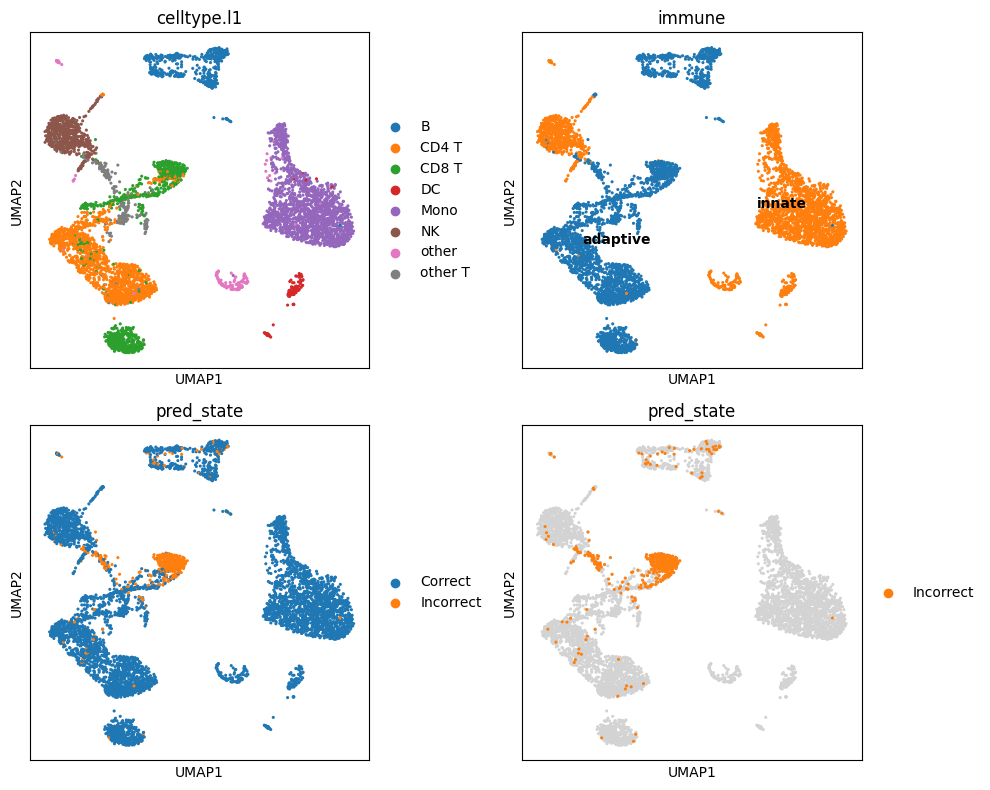

In [ ]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2)


ax = plt.subplot(gs[0])
sc.pl.umap(adata_new, color = 'celltype.l1', ax=ax, show=False, s=20)

ax = plt.subplot(gs[1])
sc.pl.umap(adata_new, color = 'immune', ax=ax, show=False, s=20, legend_loc= 'on data')

ax=plt.subplot(gs[2])
sc.pl.umap(adata_new, color = 'pred_state', ax=ax, s=20, show=False)

ax=plt.subplot(gs[3])
sc.pl.umap(adata_new, s=20, ax=ax, show=False)
sc.pl.umap(adata_new[adata_new.obs.pred_state=='Incorrect'], color = 'pred_state', ax=ax, s=20, show=False)

plt.tight_layout()

Finally, let's look at how the model performance varies by cell type in both the test data and the new dataset

Text(0.5, 1.0, 'Test data')

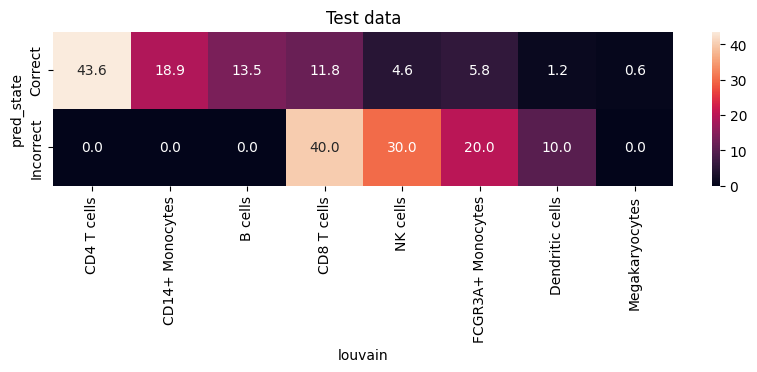

In [ ]:
pred_tally_old = pd.crosstab(adata_test.obs['louvain'], adata_test.obs['pred_state']).T


plt.figure(figsize=(10,2))
ax=plt.axes()
sns.heatmap(pred_tally_old.div(pred_tally_old.sum(axis=1), axis=0)*100, ax=ax, annot=True, fmt = ".1f")
plt.title("Test data")

Text(0.5, 1.0, 'New dataset')

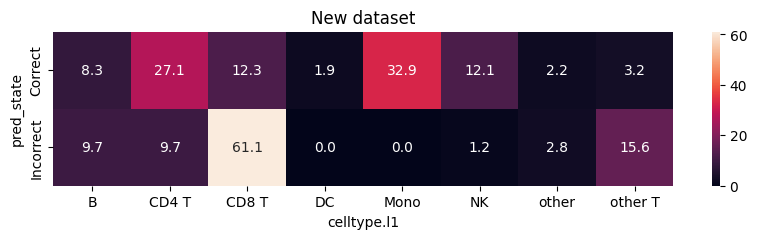

In [ ]:
pred_tally = pd.crosstab(adata_new.obs['celltype.l1'], adata_new.obs['pred_state']).T


plt.figure(figsize=(10,2))
ax=plt.axes()
sns.heatmap(pred_tally.div(pred_tally.sum(axis=1), axis=0)*100, ax=ax, annot=True, fmt = ".1f")
plt.title("New dataset")

In both cases, the model struggles to accurately classify CD8 T-cells as adaptive, likely due to the presence of a subset exhibiting "innate-like" properties. Notably, [Choi et al.](https://www.sciencedirect.com/science/article/pii/S2211124723002474) reported elevated KIR gene expression in innate-like CD8 T-cells. If the observed misclassification is associated with an innate signature, we would expect to see a difference in KIR gene expression between the misclassified and correctly classified CD8 T-cell subsets.

We can test this hypothesis by calculating a module score for KIR genes and comparing its distribution between correctly and incorrectly classified CD8 T-cells.

In [ ]:
adata_new.obs['new_var'] = adata_new.obs.pred_state.astype(str) + "_" + adata_new.obs['celltype.l1'].astype(str)

In [ ]:
import re
kir_genes = list(filter(lambda x:re.match("^KIR",x), adata_new.var_names.values))

In [ ]:
sc.tl.score_genes(adata_new, kir_genes)

<Axes: xlabel='new var', ylabel='score'>

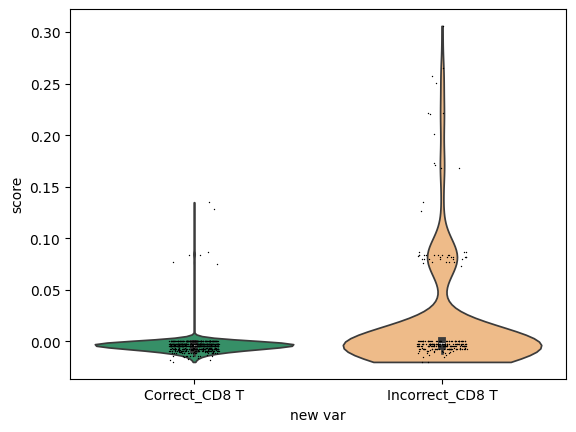

In [ ]:
ax = plt.axes()
sc.pl.violin(adata_new[adata_new.obs['celltype.l1']=='CD8 T'], keys = 'score', groupby = 'new_var', ax=ax, show=False, inner='box')
# plt.yscale('log')

In [ ]:
from scipy.stats import mannwhitneyu

p_val = mannwhitneyu(x = adata_new.obs.loc[adata_new.obs['new_var'] == 'Correct_CD8 T','score'].values,
             y = adata_new.obs.loc[adata_new.obs['new_var'] == 'Incorrect_CD8 T','score'].values)[1]

print(p_val)

2.5566041971677556e-05


We can see that indeed, the CD8 T-cells that were incorrectly annotated as 'innate' scored significantly higher for KIR genes compared to the CD 8 T-cells that were correctly annotated.